Dataset Docs:

Lisensi: https://creativecommons.org/licenses/by-sa/4.0/
versi: 1.0 (Agt 2018)


Penjelasan Label
0: sms normal
1: fraud atau penipuan
2: promo

Catatan:
Data dibersihkan dari  informasi pribadi. Nama diganti dengan "nama1"

Jumlah data: 1143
Jumlah per kelas:
0: 569
1: 335
2: 239

Cara mensitasi:
"Rahmi, F. and Wibisono, Y.  (2016). Aplikasi SMS Spam Filtering pada Android menggunakan Naive Bayes, Unpublished manuscript."

Menerima sumbangan data spam SMS, silakan kontak yudi@upi.edu

In [78]:
from google.colab import drive;
from sklearn.model_selection import train_test_split;

import pandas;

In [79]:
drive.mount('/content/drive');

base_path = "/content/drive/MyDrive/Collab Dataset/dataset_sms/";
file_name = "dataset_sms_spam_v1.csv";

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Pre-Processing

In [80]:
dataframe = pandas.read_csv(base_path + file_name);

dataframe.shape

(1143, 2)

In [81]:
dataframe.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


This part is data splitting and performing One-Hot Encoding for `label`

The splits will be 70 : 15 : 15 for train : test : val

In [82]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [83]:
tokenizer = Tokenizer(num_words = 1000, oov_token = "<OOV>");
tokenizer.fit_on_texts(dataframe["Teks"]);

word_index = tokenizer.word_index

In [84]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(dataframe["Teks"])
dataframe["Teks"] = pad_sequences(sequences, maxlen = 1000, padding = "post", truncating = "post")

In [85]:
feature_train, feature_test, label_train, label_test = train_test_split(
    dataframe.drop(columns = ["label"]),
    dataframe["label"],
    train_size=0.7,
    random_state = 42
);

feature_test, feature_val, label_test, label_val = train_test_split(
    feature_test,
    label_test,
    train_size=0.5,
    random_state = 42
);

label_train = pandas.get_dummies(label_train, prefix = "label");
label_test = pandas.get_dummies(label_test, prefix = "label");
label_val = pandas.get_dummies(label_val, prefix = "label");

In [86]:
import tensorflow;
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Embedding, SimpleRNN, BatchNormalization, LSTM, Bidirectional, GRU;

import matplotlib.pyplot as plt;

from tensorflow.keras.utils import plot_model;
from tensorflow.keras.callbacks import EarlyStopping;


In [87]:
class RNNModel:
  def __init__(self):
    self.input = Input(shape=(1000,))
    self.embedding = Embedding(1000, 1000, input_length = 1000);
    self.rnn = SimpleRNN(128, activation = "tanh", recurrent_initializer = 'glorot_uniform');
    self.bn1 = BatchNormalization();
    self.dense1 = Dense(6, activation = "relu");
    self.output = Dense(3, activation = "softmax");

  # Early stopping after loss are not improved for some epochs
  def _callback_early_stopping(self):
      early_stopping_tolerance = 50;
      return EarlyStopping(
          monitor = "val_loss",
          patience = early_stopping_tolerance,
          restore_best_weights = True
      );

  def fitting(self):
      model = Sequential();

      model.add(self.input);

      model.add(self.embedding);
      model.add(self.rnn);

      model.add(self.bn1);

      model.add(self.dense1);
      model.add(self.output);

      model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]);
      model.summary();

      plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);


      history = model.fit(
          feature_train,
          label_train,
          epochs = 300,
          batch_size = 64,
          validation_data = (feature_val, label_val),
          # callbacks = [self._callback_early_stopping()]
      );

      # Plot training history
      plt.plot(history.history['loss'], label='Training Loss');
      plt.plot(history.history['val_loss'], label='Validation Loss');
      plt.xlabel('Epoch');
      plt.ylabel('Loss');
      plt.legend();
      plt.show();

      return model;

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1000, 1000)        1000000   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 128)               144512    
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 6)                 774       
                                                                 
 dense_15 (Dense)            (None, 3)                 21        
                                                                 
Total params: 1145819 (4.37 MB)
Trainable params: 1145563 (4.37 MB)
Non-trainable params: 256 (1.00 KB)
________________

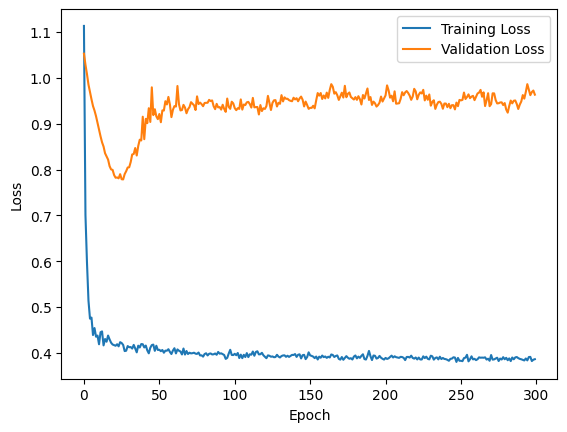

6/6 [==============================] - 0s 4ms/step - loss: 1.0111 - accuracy: 0.7018
Test accuracy SimpleRNN: 0.7017543911933899


In [88]:
rnn = RNNModel();
model = rnn.fitting();

test_loss, test_acc = model.evaluate(feature_test, label_test)
print(f'Test accuracy SimpleRNN: {test_acc}')

In [89]:
class LSTMModel:
  def __init__(self):
    self.input = Input(shape=(1000,))
    self.embedding = Embedding(1000, 1000, input_length = 1000);
    self.rnn = LSTM(128, activation = "tanh", recurrent_initializer = 'glorot_uniform');
    self.bn1 = BatchNormalization();
    self.dense1 = Dense(6, activation = "relu");
    self.output = Dense(3, activation = "softmax");

  # Early stopping after loss are not improved for some epochs
  def _callback_early_stopping(self):
      early_stopping_tolerance = 50;
      return EarlyStopping(
          monitor = "val_loss",
          patience = early_stopping_tolerance,
          restore_best_weights = True
      );

  def fitting(self):
      model = Sequential();

      model.add(self.input);

      model.add(self.embedding);
      model.add(self.rnn);

      model.add(self.bn1);

      model.add(self.dense1);
      model.add(self.output);

      model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]);
      model.summary();

      plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);


      history = model.fit(
          feature_train,
          label_train,
          epochs = 300,
          batch_size = 64,
          validation_data = (feature_val, label_val),
          # callbacks = [self._callback_early_stopping()]
      );

      # Plot training history
      plt.plot(history.history['loss'], label='Training Loss');
      plt.plot(history.history['val_loss'], label='Validation Loss');
      plt.xlabel('Epoch');
      plt.ylabel('Loss');
      plt.legend();
      plt.show();

      return model;

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1000, 1000)        1000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               578048    
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 6)                 774       
                                                                 
 dense_17 (Dense)            (None, 3)                 21        
                                                                 
Total params: 1579355 (6.02 MB)
Trainable params: 1579099 (6.02 MB)
Non-trainable params: 256 (1.00 KB)
________________

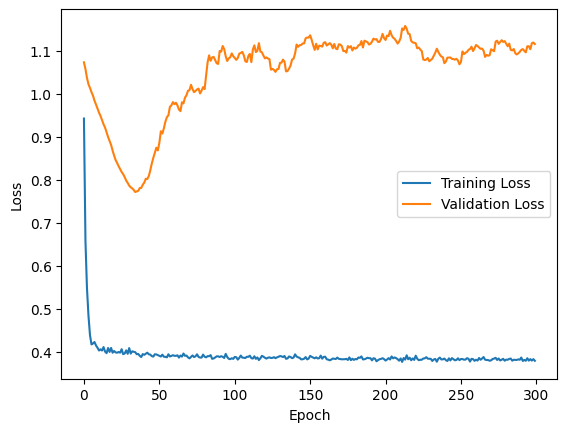

6/6 [==============================] - 0s 4ms/step - loss: 1.1038 - accuracy: 0.7076
Test accuracy LSTM: 0.707602322101593


In [90]:
lstm = LSTMModel();
model = lstm.fitting();

test_loss, test_acc = model.evaluate(feature_test, label_test)
print(f'Test accuracy LSTM: {test_acc}')

In [91]:
class BLSTMModel:
  def __init__(self):
    self.input = Input(shape=(1000,))
    self.embedding = Embedding(1000, 1000, input_length = 1000);
    self.rnn = Bidirectional(LSTM(128, activation = "tanh", recurrent_initializer = 'glorot_uniform'));
    self.bn1 = BatchNormalization();
    self.dense1 = Dense(6, activation = "relu");
    self.output = Dense(3, activation = "softmax");

  # Early stopping after loss are not improved for some epochs
  def _callback_early_stopping(self):
      early_stopping_tolerance = 50;
      return EarlyStopping(
          monitor = "val_loss",
          patience = early_stopping_tolerance,
          restore_best_weights = True
      );

  def fitting(self):
      model = Sequential();

      model.add(self.input);

      model.add(self.embedding);
      model.add(self.rnn);

      model.add(self.bn1);

      model.add(self.dense1);
      model.add(self.output);

      model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]);
      model.summary();

      plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);


      history = model.fit(
          feature_train,
          label_train,
          epochs = 300,
          batch_size = 64,
          validation_data = (feature_val, label_val),
          # callbacks = [self._callback_early_stopping()]
      );

      # Plot training history
      plt.plot(history.history['loss'], label='Training Loss');
      plt.plot(history.history['val_loss'], label='Validation Loss');
      plt.xlabel('Epoch');
      plt.ylabel('Loss');
      plt.legend();
      plt.show();

      return model;

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1000, 1000)        1000000   
                                                                 
 bidirectional (Bidirection  (None, 256)               1156096   
 al)                                                             
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 6)                 1542      
                                                                 
 dense_19 (Dense)            (None, 3)                 21        
                                                                 
Total params: 2158683 (8.23 MB)
Trainable params: 2158

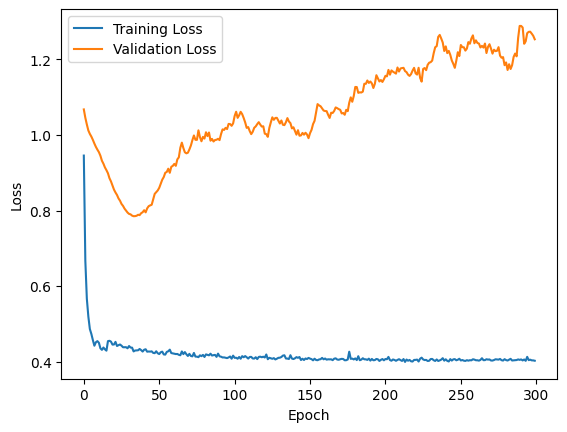

6/6 [==============================] - 0s 5ms/step - loss: 1.3823 - accuracy: 0.6374
Test accuracy BLSTM: 0.6374269127845764


In [92]:
blstm = BLSTMModel();
model = blstm.fitting();

test_loss, test_acc = model.evaluate(feature_test, label_test)
print(f'Test accuracy BLSTM: {test_acc}')

In [93]:
class GRUModel:
  def __init__(self):
    self.input = Input(shape=(1000,))
    self.embedding = Embedding(1000, 1000, input_length = 1000);
    self.rnn = GRU(128, activation = "tanh", recurrent_initializer = 'glorot_uniform');
    self.bn1 = BatchNormalization();
    self.dense1 = Dense(6, activation = "relu");
    self.output = Dense(3, activation = "softmax");

  # Early stopping after loss are not improved for some epochs
  def _callback_early_stopping(self):
      early_stopping_tolerance = 50;
      return EarlyStopping(
          monitor = "val_loss",
          patience = early_stopping_tolerance,
          restore_best_weights = True
      );

  def fitting(self):
      model = Sequential();

      model.add(self.input);

      model.add(self.embedding);
      model.add(self.rnn);

      model.add(self.bn1);

      model.add(self.dense1);
      model.add(self.output);

      model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]);
      model.summary();

      plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);


      history = model.fit(
          feature_train,
          label_train,
          epochs = 300,
          batch_size = 64,
          validation_data = (feature_val, label_val),
          # callbacks = [self._callback_early_stopping()]
      );

      # Plot training history
      plt.plot(history.history['loss'], label='Training Loss');
      plt.plot(history.history['val_loss'], label='Validation Loss');
      plt.xlabel('Epoch');
      plt.ylabel('Loss');
      plt.legend();
      plt.show();

      return model;

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1000, 1000)        1000000   
                                                                 
 gru (GRU)                   (None, 128)               433920    
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 6)                 774       
                                                                 
 dense_21 (Dense)            (None, 3)                 21        
                                                                 
Total params: 1435227 (5.47 MB)
Trainable params: 1434971 (5.47 MB)
Non-trainable params: 256 (1.00 KB)
_______________

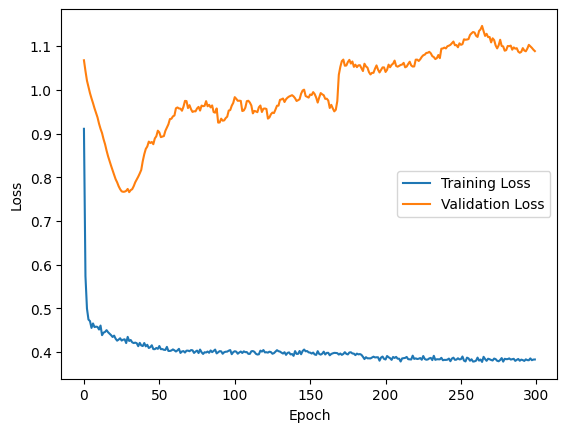

6/6 [==============================] - 0s 4ms/step - loss: 0.9939 - accuracy: 0.7076
Test accuracy GRU: 0.707602322101593


In [94]:
gru = GRUModel();
model = gru.fitting();

test_loss, test_acc = model.evaluate(feature_test, label_test)
print(f'Test accuracy GRU: {test_acc}')